## 1. Business Understanding 
The purpose of this project is doing sentiment analysis on reviews of health and personal care products from Amazon.
## 2. Data Understanding
The dataset includes 9 attributes:

*   reviewerID - ID of the reviewer, e.g. A1RSDE90N6RSZF
*   asin - ID of the product, e.g. 0000013714


*   reviewerName - name of the reviewer
*   helpful - helpfulness rating of the review, e.g. 2/3



*   reviewText - text of the review
*   overall - rating of the product


*   summary - summary of the review
*   unixReviewTime - time of the review (unix time)


*   reviewTime - time of the review (raw)


## 2.1 Data Ingestion

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [0]:
import pandas as pd
import numpy as np

In [0]:
df = pd.read_json("/content/gdrive/My Drive/Individual Project/reviews_Health_and_Personal_Care_5.json", lines=True)

In [0]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,159985130X,"[1, 1]",5,This is a great little gadget to have around. ...,"01 5, 2011",ALC5GH8CAMAI7,AnnN,Handy little gadget,1294185600
1,159985130X,"[1, 1]",4,I would recommend this for a travel magnifier ...,"02 18, 2012",AHKSURW85PJUE,"AZ buyer ""AZ buyer""",Small & may need to encourage battery,1329523200
2,159985130X,"[75, 77]",4,What I liked was the quality of the lens and t...,"06 8, 2010",A38RMU1Y5TDP9,"Bob Tobias ""Robert Tobias""",Very good but not great,1275955200
3,159985130X,"[56, 60]",4,Love the Great point light pocket magnifier! ...,"02 8, 2008",A1XZUG7DFXXOS4,Cat lover,great addition to your purse,1202428800
4,159985130X,"[1, 1]",5,This is very nice. You pull out on the magnifi...,"08 16, 2011",A1MS3M7M7AM13X,Cricketoes,Very nice and convenient.,1313452800


## 2.2 Data Cleaning

**Values of  ‘helpful' column are list. So we convert the list to helpful rate, which is the number of helpfulness ratings divided by the number of reviews**

In [0]:
def helpful(x):
  if int(x[1]) == 0:
    helpful = 0
  else:
    helpful = float(x[0]) /float(x[1])
  return helpful

In [0]:
# Create helpful rate column
df['helpfulrate'] = df['helpful'].apply(lambda x: helpful(x))

In [0]:
# Create review number column
df['reviewnumber'] = df['helpful'].apply(lambda x: int(x[1]))

**The current review time column is not in standard time format, convert it to time object**

In [0]:
import datetime
def date(x):
  month = int(x.split(' ')[0])
  day = int(x.split(' ')[1].split(',')[0])
  year = int(x.split(' ')[2])
  date = datetime.datetime(year, month, day)
  return date

In [0]:
df['reviewdate'] = df['reviewTime'].apply(lambda x: date(x))

In [0]:
df.head()


,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,helpfulrate,reviewnumber,reviewdate
0,159985130X,"[1, 1]",5,This is a great little gadget to have around. ...,"01 5, 2011",ALC5GH8CAMAI7,AnnN,Handy little gadget,1294185600,1.000000,1,2011-01-05
1,159985130X,"[1, 1]",4,I would recommend this for a travel magnifier ...,"02 18, 2012",AHKSURW85PJUE,"AZ buyer ""AZ buyer""",Small & may need to encourage battery,1329523200,1.000000,1,2012-02-18
2,159985130X,"[75, 77]",4,What I liked was the quality of the lens and t...,"06 8, 2010",A38RMU1Y5TDP9,"Bob Tobias ""Robert Tobias""",Very good but not great,1275955200,0.974026,77,2010-06-08
3,159985130X,"[56, 60]",4,Love the Great point light pocket magnifier! ...,"02 8, 2008",A1XZUG7DFXXOS4,Cat lover,great addition to your purse,1202428800,0.933333,60,2008-02-08
4,159985130X,"[1, 1]",5,This is very nice. You pull out on the magnifi...,"08 16, 2011",A1MS3M7M7AM13X,Cricketoes,Very nice and convenient.,1313452800,1.000000,1,2011-08-16


In [0]:
# Drop helpful and review time columns
df = df.drop(['helpful', 'reviewTime'], axis=1)


**Create a sentiment column based on overall rating: if the rating is greater than 3, label the review as 'positive' (true) and if the rating is equal to or lower than 3, label the review as 'negative' (false)**

In [0]:
df['sentiment'] = df['overall']>3

In [0]:
df.head()

,asin,overall,reviewText,reviewerID,reviewerName,summary,unixReviewTime,helpfulrate,reviewnumber,reviewdate,sentiment
0,159985130X,5,This is a great little gadget to have around. ...,ALC5GH8CAMAI7,AnnN,Handy little gadget,1294185600,1.000000,1,2011-01-05,True
1,159985130X,4,I would recommend this for a travel magnifier ...,AHKSURW85PJUE,"AZ buyer ""AZ buyer""",Small & may need to encourage battery,1329523200,1.000000,1,2012-02-18,True
2,159985130X,4,What I liked was the quality of the lens and t...,A38RMU1Y5TDP9,"Bob Tobias ""Robert Tobias""",Very good but not great,1275955200,0.974026,77,2010-06-08,True
3,159985130X,4,Love the Great point light pocket magnifier! ...,A1XZUG7DFXXOS4,Cat lover,great addition to your purse,1202428800,0.933333,60,2008-02-08,True
4,159985130X,5,This is very nice. You pull out on the magnifi...,A1MS3M7M7AM13X,Cricketoes,Very nice and convenient.,1313452800,1.000000,1,2011-08-16,True


## 2.3 EDA

**Top 5 products with most reviews**

In [0]:
df['asin'].value_counts().head(5)

B0037KMI0U    1089
B0010JLMO8     767
B001KXZ808     699
B0049LUI9O     528
B000GIPJY8     475
Name: asin, dtype: int64

**Top 5 users with most reviews**

In [0]:
df['reviewerID'].value_counts().head(5)

A3NHUQ33CFH3VM    292
A1UQBFCERIP7VJ    264
A3OXHLG6DIBRW8    250
A34BZM6S9L7QI4    246
ALNFHVS3SC4FV     219
Name: reviewerID, dtype: int64

**Number of reviews overtime**


From the plot below, we can see as the number of reviews increases overtime. The oldest review can be traced back to 2000-12-09 and the lastest review was made on 2014-07-23. From the trend of the number of reviews we can see the growth of Amazon's business

In [0]:
print(df['reviewdate'].max())
print(df['reviewdate'].min())

2014-07-23 00:00:00
2000-12-09 00:00:00


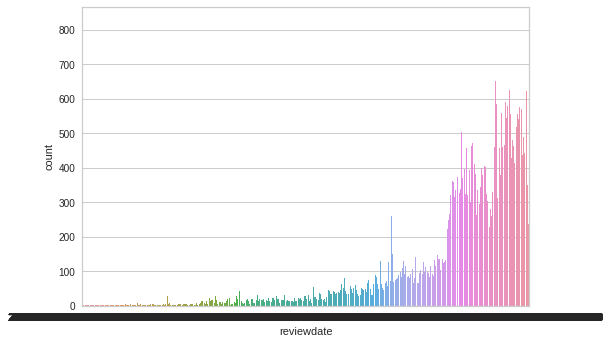

In [0]:
sns.countplot(x='reviewdate',data=df)

In [0]:
df.groupby(['reviewdate']).count()

In [0]:
# After cleaning the data, we can get info of the data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346355 entries, 0 to 346354
Data columns (total 10 columns):
asin              346355 non-null object
overall           346355 non-null int64
reviewText        346355 non-null object
reviewerID        346355 non-null object
reviewerName      343304 non-null object
summary           346355 non-null object
unixReviewTime    346355 non-null int64
helpfulrate       346355 non-null float64
reviewnumber      346355 non-null int64
reviewdate        346355 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 26.4+ MB


**Length of characters in review**

We find most of the reviews have number of characters less than 500. But there are some outliers, extremely long reviews. For example, one review even has nearly 30000 characters! So out of curiosity, we choose one long review to see what the user said. We find the user is making comment on a yogurt maker. But what the user said is quite ambiguous. Hard to tell what he is really talking about...

In [0]:
df['reviewlen'] = [len(t) for t in df.reviewText]

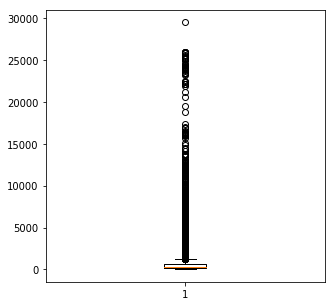

In [0]:
fig,ax = plt.subplots(figsize=(5,5))
plt.boxplot(df.reviewlen)
plt.show()

In [0]:
df[df['reviewlen'] > 25000].iloc[0]['reviewText']

'Euro-Cuisine YM100 Automatic Yogurt Maker***MIX IS DAIRY***Here is an admittedly long rambling essay about food, including a review of 3 products with links to those products. The honey is not from amazon, but amazon sells organic honey. I don\'t think any of it is labeled no GMO yet. Yogurt, like beer, kombucha and bread is an art and a metaphor. If distilling water is a daily ritual along zen lines of "chop wood carry water" to survive physically and to provide a focal point for other life interests, then my water purification is a metaphor for releasing toxins. My new yogurt ritual is a metaphor for growing the right symbiotic organisms, which includes fungi (beer, bread, medicines), flowers (decorations and medicines) and gives a visual to the idea of cultivating friendly ideas just as one cultures friendly bacteria in a glass jar. The clumpy yogurt is a metaphor for entropy. Smooth yogurt is a metaphor for orderly change slowly replacing something at least I grew up on from the l

**Count of ratings**

Next, we take a look at the distribution of ratings. We can see most of the reviews have high ratings: 5. The ratings are skewed.

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

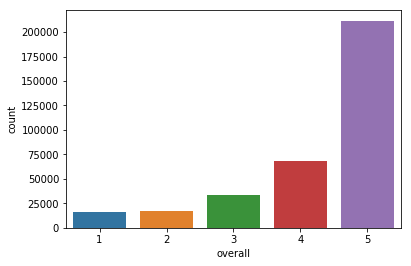

In [0]:
sns.countplot(x='overall',data=df)

**Popluar products and number of reviews**

We use violin plot to see whether popular products (those having many reviews) tend to have higher scores. The plot supports our guess. We can see products with more than 3000 reviews all have ratings over 4.

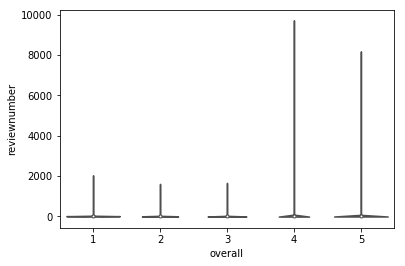

In [0]:
sns.violinplot(x="overall", y="reviewnumber", data=df,palette='rainbow')

**Wordcloud**

Then we look at the common words in positive reviews and negative reviews. We find in positive reviews, there are words like great, light, quality, recommend, nice, easy, handy and so on. For negative reviews, common words are money, worst, horrible, smaller and so on.

In [0]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [0]:
df_positive = df[df.overall > 3]
positive_text = df_positive['reviewText'].values

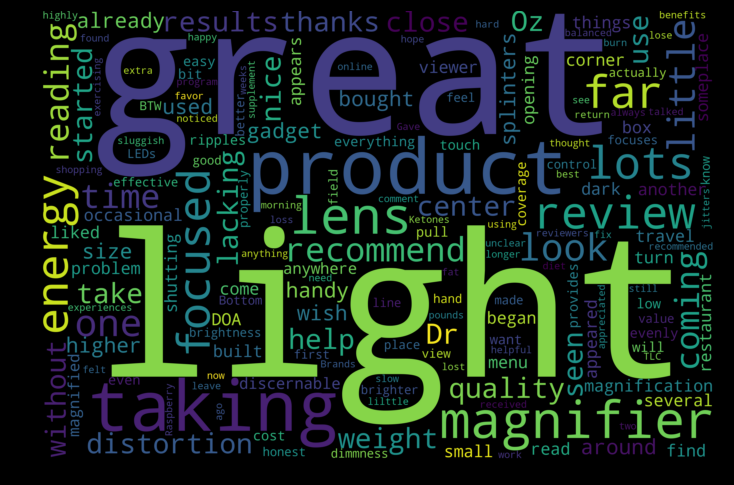

In [0]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(positive_text))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [0]:
df_negative = df[df.overall < 3]
negative_text = df_negative['reviewText'].values

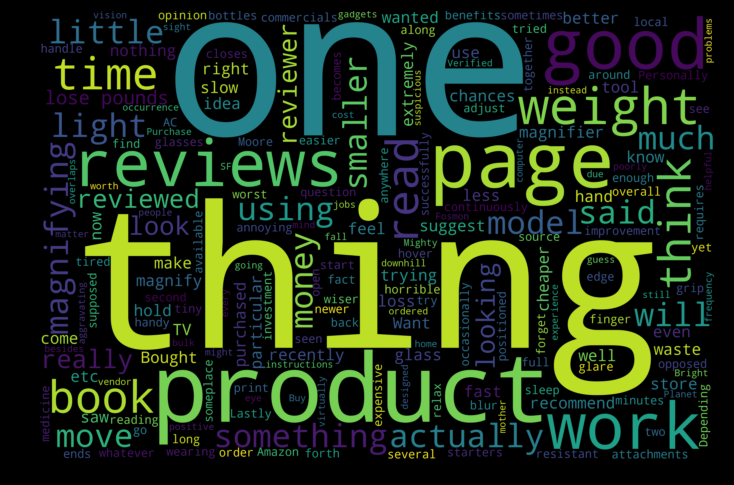

In [0]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(negative_text))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## 3. Data Preparation

We know the original dataset has more positive reviews than negative ones. The dataset has over 350K records, too big for modeling. So we only use 5000 negative reviews and 5000 positive reviews to run our models..

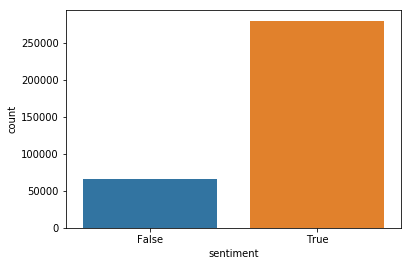

In [0]:
sns.countplot(x='sentiment',data=df)

In [0]:
print(df[df['sentiment'] == False]['reviewText'].nunique())
print(df[df['sentiment'] == True]['reviewText'].nunique())

66537
279637


In [0]:
df_negative = df[df['sentiment'] == False]
df_positive = df[df['sentiment'] == True]

In [0]:
df_negative_subset = df_negative.sample(n=5000, random_state=2)
df_positive_subset = df_positive.sample(n=5000, random_state=2)

In [0]:
# Create a subset dataset which has 5000 positive reviews and 5000 negative reviews
df_subset = pd.concat([df_negative_subset, df_positive_subset], ignore_index=True)

In [0]:
df_subset = df_subset.sample(frac=1).reset_index(drop=True)

In [0]:
df_subset.head()

,asin,overall,reviewText,reviewerID,reviewerName,summary,unixReviewTime,helpfulrate,reviewnumber,reviewdate,sentiment
0,B000143C0K,5,"This trimmer was a real surprise. Strong, qui...",A3UMRE29ZC60C7,"alfafemme ""alfafemme""",Perfect for professional use,1375142400,0.0,0,2013-07-30,True
1,B003N4AVKE,4,I'm happy with my scale purchase. First of all...,A2Z2OCAY9NHD78,Nicole,Stylish and weight accurate,1394150400,0.0,0,2014-03-07,True
2,B0019LU5K4,3,I like this product although I'm not sure if i...,A15H8H0ZE3D28D,Patricia Davis,Great product,1383436800,0.5,2,2013-11-03,False
3,B001F51VS4,2,The light floral fragrance is excellent. Femi...,A158M54UZXY20E,"Beesusie ""Beesusie""","Semi-liquid, paste-like antiperspirant and deo...",1278892800,0.5,2,2010-07-12,False
4,B001395D8Q,5,"This works for all types of dairy intolerance,...",A2TB6WI33B7FN6,"Gloria D. Krein ""GDK""",100% Effective,1357689600,0.8,5,2013-01-09,True


## 4 & 5. Modeling & Evaluation

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn import metrics
from sklearn.model_selection import train_test_split   
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [0]:
# Text Vectorization : TF-IDF & Bag of Words
Stopwords = list(ENGLISH_STOP_WORDS)
tfidf_vectorizor = TfidfVectorizer(min_df=5, 
                             max_df=0.5,
                             analyzer='word',
                             strip_accents='unicode',
                             ngram_range=(1, 3),
                             sublinear_tf=True, 
                             smooth_idf=True,
                             use_idf=True,
                             stop_words=Stopwords)

BoW_vectorizer = CountVectorizer(strip_accents='unicode',
                                 stop_words=Stopwords,
                                 ngram_range=(1,3),
                                 analyzer='word',
                                 min_df=5,
                                 max_df=0.5)

In [0]:
# Train and test data split
review = np.array(df_subset['reviewText'])
sentiment = np.array(df_subset['sentiment'])

review_train, review_test, sentiment_train, sentiment_test = train_test_split(review, sentiment, test_size=0.2, random_state=4)

#TF-IDF
train_tfidfmatrix = tfidf_vectorizor.fit_transform(review_train)
test_tfidfmatrix = tfidf_vectorizor.transform(review_test)

#Vectorizer (Bag of Words Model)
train_simplevector = BoW_vectorizer.fit_transform(review_train)
test_simplevector = BoW_vectorizer.transform(review_test)

##Logistic Regression

### TF-IDF

In [0]:
from yellowbrick.classifier import ConfusionMatrix
from sklearn import datasets, metrics

In [0]:
from sklearn.metrics import classification_report

In [0]:
param_grid = [{'penalty' : ['l1', 'l2']}, {'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
                 {'max_iter' : range(100, 1000)}]

In [0]:
grid = GridSearchCV(LogisticRegression(),param_grid,refit=True)

In [0]:
grid.fit(train_tfidfmatrix, sentiment_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'penalty': ['l1', 'l2']},
                         {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                     'saga']},
                         {'max_iter': range(100, 1000)}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None,

In [0]:
grid.best_params_

{'solver': 'lbfgs'}

In [0]:
grid_predictions = grid.predict(test_tfidfmatrix)

**Model Evaluation**

In [0]:
print(classification_report(sentiment_test,grid_predictions))

              precision    recall  f1-score   support

       False       0.78      0.79      0.78      1015
        True       0.78      0.77      0.77       985

    accuracy                           0.78      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.78      0.78      0.78      2000



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.779

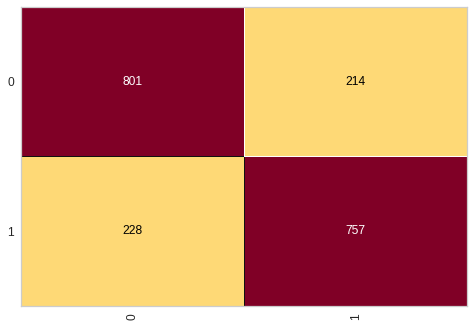

In [0]:
cm = ConfusionMatrix(grid, classes=[0,1])
cm.fit(train_tfidfmatrix, sentiment_train)
cm.score(test_tfidfmatrix, sentiment_test)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


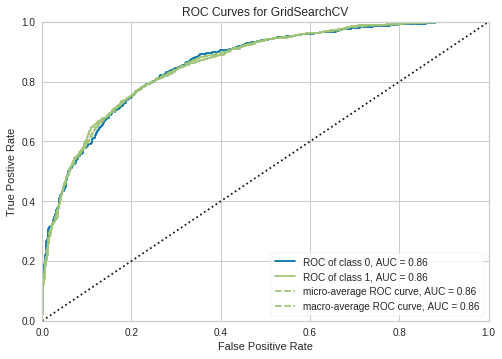

In [0]:
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(grid, classes=[0,1])

visualizer.fit(train_tfidfmatrix, sentiment_train)  
visualizer.score(test_tfidfmatrix, sentiment_test)  
g = visualizer.poof() 

### Bag of Words

In [0]:
param_grid = [{'penalty' : ['l1', 'l2']}, {'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
                 {'max_iter' : range(100, 1000)}]

In [0]:
grid = GridSearchCV(LogisticRegression(),param_grid,refit=True)

In [0]:
grid.fit(train_simplevector, sentiment_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'penalty': ['l1', 'l2']},
                         {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                     'saga']},
                         {'max_iter': range(100, 1000)}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None,

In [0]:
grid.best_params_

{'penalty': 'l2'}

In [0]:
grid_predictions = grid.predict(test_simplevector)

**Model Evaluation**

In [0]:
print(classification_report(sentiment_test,grid_predictions))

              precision    recall  f1-score   support

       False       0.76      0.74      0.75      1015
        True       0.74      0.76      0.75       985

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

0.7535

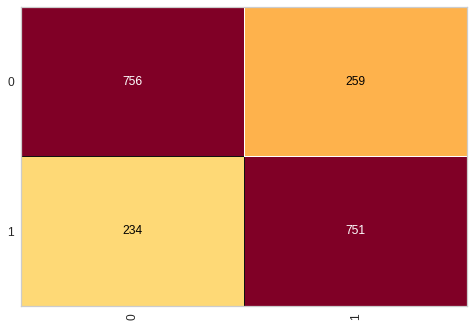

In [0]:
cm = ConfusionMatrix(grid, classes=[0,1])
cm.fit(train_simplevector, sentiment_train)
cm.score(test_simplevector, sentiment_test)

## SVM

### TF-IDF

In [0]:
param_grid = {'C': [0.1,1,10, 100], 'gamma': [1,0.1,0.01], 'kernel': ['rbf']} 

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
grid = GridSearchCV(SVC(),param_grid,refit=True)

In [0]:
grid.fit(train_tfidfmatrix, sentiment_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
grid.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [0]:
grid_predictions = grid.predict(test_tfidfmatrix)

**Model Evaluation**

In [0]:
print(classification_report(sentiment_test,grid_predictions))

              precision    recall  f1-score   support

       False       0.77      0.79      0.78      1015
        True       0.78      0.76      0.77       985

    accuracy                           0.77      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.77      0.77      0.77      2000



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.773

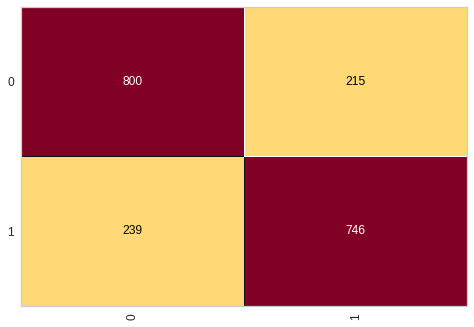

In [0]:
cm = ConfusionMatrix(grid, classes=[0,1])
cm.fit(train_tfidfmatrix, sentiment_train)
cm.score(test_tfidfmatrix, sentiment_test)

In [0]:
visualizer = ROCAUC(grid, classes=[0,1])

visualizer.fit(train_tfidfmatrix, sentiment_train)  
visualizer.score(test_tfidfmatrix, sentiment_test)  
g = visualizer.poof() 

### Bage of Words

In [0]:
param_grid = {'C': [0.1,1,10, 100], 'gamma': [1,0.1,0.01], 'kernel': ['rbf']} 

In [0]:
grid = GridSearchCV(SVC(),param_grid,refit=True)

In [0]:
grid.fit(train_simplevector, sentiment_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
grid.best_params_

{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}

In [0]:
grid_predictions = grid.predict(test_simplevector)

**Model Evaluation**

In [0]:
print(classification_report(sentiment_test,grid_predictions))

              precision    recall  f1-score   support

       False       0.75      0.78      0.77      1015
        True       0.77      0.73      0.75       985

    accuracy                           0.76      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.76      0.76      0.76      2000



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.756

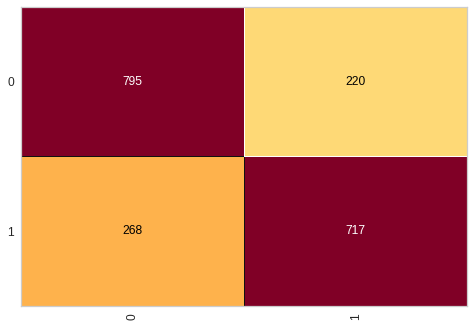

In [0]:
cm = ConfusionMatrix(grid, classes=[0,1])
cm.fit(train_simplevector, sentiment_train)
cm.score(test_simplevector, sentiment_test)

In [0]:
visualizer = ROCAUC(grid, classes=[0,1])

visualizer.fit(train_simplevector, sentiment_train)  
visualizer.score(test_simplevector, sentiment_test)  
g = visualizer.poof() 

## Random Forest

### TF-IDF

In [0]:
param_grid = {'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth' : [4,5,6,7,8], 'criterion' :['gini', 'entropy']}

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
grid = GridSearchCV(RandomForestClassifier(),param_grid,refit=True)

In [0]:
grid.fit(train_tfidfmatrix, sentiment_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [0]:
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 500}

In [0]:
grid_predictions = grid.predict(test_tfidfmatrix)

**Model Evaluation**

In [0]:
print(classification_report(sentiment_test,grid_predictions))

              precision    recall  f1-score   support

       False       0.75      0.68      0.72      1015
        True       0.70      0.77      0.73       985

    accuracy                           0.73      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.73      0.73      0.73      2000



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.722

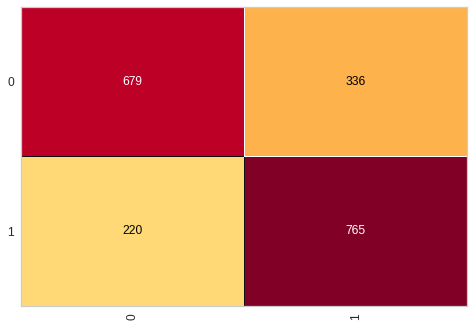

In [0]:
cm = ConfusionMatrix(grid, classes=[0,1])
cm.fit(train_tfidfmatrix, sentiment_train)
cm.score(test_tfidfmatrix, sentiment_test)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


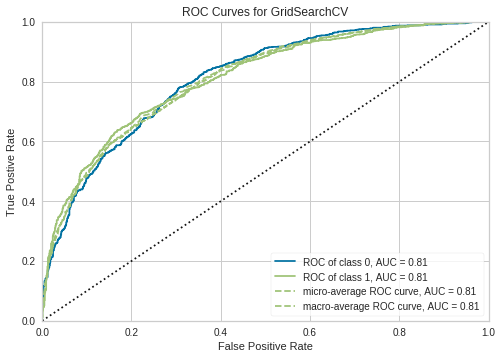

In [0]:
visualizer = ROCAUC(grid, classes=[0,1])

visualizer.fit(train_tfidfmatrix, sentiment_train)  
visualizer.score(test_tfidfmatrix, sentiment_test)  
g = visualizer.poof() 

### Bag of Words

In [0]:
param_grid = {'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth' : [4,5,6,7,8], 'criterion' :['gini', 'entropy']}

In [0]:
grid = GridSearchCV(RandomForestClassifier(),param_grid,refit=True)

In [0]:
grid.fit(train_simplevector, sentiment_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [0]:
grid.fit(train_tfidfmatrix, sentiment_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [0]:
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 500}

In [0]:
grid_predictions = grid.predict(test_tfidfmatrix)

**Model Evaluation**

In [0]:
print(classification_report(sentiment_test,grid_predictions))

              precision    recall  f1-score   support

       False       0.76      0.68      0.71      1015
        True       0.70      0.77      0.74       985

    accuracy                           0.73      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.73      0.73      0.72      2000



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.7165

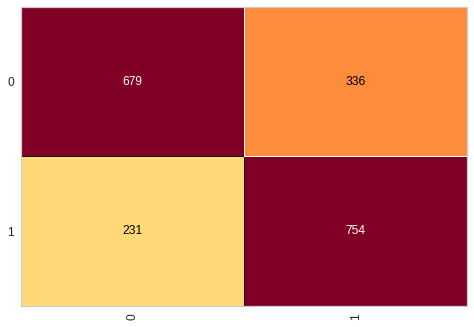

In [0]:
cm = ConfusionMatrix(grid, classes=[0,1])
cm.fit(train_tfidfmatrix, sentiment_train)
cm.score(test_tfidfmatrix, sentiment_test)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


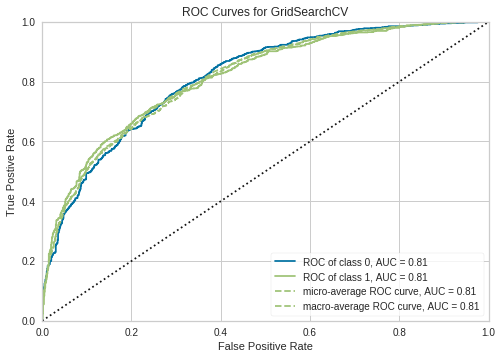

In [0]:
visualizer = ROCAUC(grid, classes=[0,1])

visualizer.fit(train_tfidfmatrix, sentiment_train)  
visualizer.score(test_tfidfmatrix, sentiment_test)  
g = visualizer.poof() 

Below is the list of model scores:


| Model| Score          
| :---:|:---: 
| Logistic Regression (TF-IDF)| 0.779 
| Logistic Regression (BoW)| 0.7535
| SVM (TF-IDF)| 0.773
| SVM (BoW)| 0.756
| Random Forest (TF-IDF)| 0.722
| Random Forest (BoW)| 0.7165


We can see logistic regression using TF-IDF has the highest model score. In this project, false positive means users who give negative reviews are predicted as positive and false negative means users who give positive reviews are predicted as negative. The cost of making false positive errors is higher than making false negative because if users are wrongly predicted as positive, customer service team will not pay attention to them or take any customer retention action, this may lead to customer churn. So in confusion matrix, we need to find the model that makes fewest false positive errors and in model scores, we need to find the model with the highest precision score.


We find logistic regression using TF-IDF makes the fewest false positive errors: 214 in total. And it also has the highest precision score. Higher AUC indicates the model is better at predicting the class. Logistic regression using TF-IDF has the highest ROC: 0.86, which is consistent with our conclusion.

**So from all evaluation aspects, logistic regression using TF-IDF is the best model.**

## 6. Topic Model

In [0]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE


### TF-IDF

In [0]:
lda = LatentDirichletAllocation(n_components=11, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

lda.fit(train_tfidfmatrix)
lda.components_

array([[0.09121043, 0.09103661, 0.09105788, ..., 0.09102012, 0.0910231 ,
        0.09102722],
       [0.0910169 , 0.09103078, 0.09105265, ..., 0.09119369, 0.09103783,
        0.09102363],
       [0.09102582, 0.09104368, 0.09103992, ..., 0.09101932, 0.09102845,
        0.0910373 ],
       ...,
       [0.09102375, 0.09104301, 0.09103248, ..., 0.09102551, 0.09102546,
        0.09103594],
       [0.09102897, 0.09104544, 0.09103425, ..., 0.09102408, 0.09101814,
        0.09101032],
       [0.09110323, 0.09104769, 0.09101447, ..., 0.0910505 , 0.0910496 ,
        0.09101829]])

In [0]:
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [0]:
nubmer_of_words=50
print("\nTopics in LDA model: ")
feature_names = tfidf_vectorizor.get_feature_names() 
print_top_words(lda, feature_names, nubmer_of_words)


Topics in LDA model: 

Topic #0:positive review ftc state california california value free birth defects defects known state california known state state california cause california cause defects reproductive birth defects reproductive write positive write positive review compelled reproductive reproductive harm defects reproductive harm review opinions disclosing compelled write compelled write positive gift manufacturer connection receive low expressed disclosing expressed disclosing accordance 255 required compelled write 16 cfr 255 cfr 255 disclosure material connection 16 cfr material connection receive receive low value ftc 16 cfr material connection cfr value free gift disclosing accordance ftc positive review opinions disclosure material accordance review required free gift free gift manufacturer receive low required compelled ftc 16 accordance ftc 16

Topic #1:better quality lower price aspirin use product going use smells bought milk furniture super ice going oil nice like b

### Bag of Words

In [0]:
lda = LatentDirichletAllocation(n_components=11, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

lda.fit(train_simplevector)
lda.components_

array([[ 1.00735501,  0.09430457,  0.09105799, ...,  0.09103633,
         0.0910231 ,  0.09103581],
       [ 0.0910532 ,  0.09107416,  0.09107262, ...,  0.67432526,
         0.09147105,  2.80886062],
       [ 0.09107972,  0.09193592,  0.09104021, ...,  3.3059943 ,
         0.09110455,  2.61529239],
       ...,
       [ 0.09120323, 20.66642517,  0.09116714, ...,  0.09102905,
         0.09102697,  0.09164403],
       [ 0.09112894,  4.81174038,  0.09215464, ...,  0.09102407,
         0.09101813,  0.09101032],
       [ 0.09321627,  0.09263471,  0.0910145 , ...,  0.09107118,
         0.0910496 ,  0.0910402 ]])

In [0]:
nubmer_of_words=50
print("\nTopics in LDA model: ")
feature_names = BoW_vectorizer.get_feature_names() 
print_top_words(lda, feature_names, nubmer_of_words)


Topics in LDA model: 

Topic #0:razor shave shaving brush teeth shaver blades blade battery head charge good like face electric close use heads toothbrush razors norelco used trimmer model better handle braun new beard using floss cream batteries years charger nice soap clean ve smooth charging old gillette job remington wet shaves cleaning sensitive time

Topic #1:bar paper bars like protein flavor soft toilet chocolate good taste calories sugar towels toilet paper great price tissue little fiber butter texture nice sweet snack roll peanut candy orange subscribe just charmin store steel pack gloves rolls stainless cold subscribe save love save tasting peanut butter carbs flavors sticky dryer paper towels size

Topic #2:use hair skin does pain like easy nice used plastic little deodorant bit easily using size long feet comfortable gel area device shower wear support trimmer small need just better legs really bags dry fit did good neck unit stick foot wax cut bag hold kit make place bo